<a href="https://colab.research.google.com/github/rithikavishwanath/Tomato_leaf_disease_TransferLearning_using_XceptionS/blob/main/Tomato_leaf_disease_TransferLearning_using_XceptionS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow import keras
from keras import Sequential 
from tensorflow.keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping as ES
from keras.utils import plot_model





from sklearn.model_selection import train_test_split

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

100% 178M/179M [00:09<00:00, 22.3MB/s]
100% 179M/179M [00:09<00:00, 19.2MB/s]


In [4]:
import zipfile
zip_ref= zipfile.ZipFile('/content/tomatoleaf.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
batch_size=64
epcohs=10
image_shape=(224,224)

In [6]:
dir_train="/content/tomato/train"
dir_val="/content/tomato/val"

In [7]:

label_names = sorted(os.listdir(dir_train))
label_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
gen_train=ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
gen_val = ImageDataGenerator(rescale=(1./255.))

In [9]:
ds_train = gen_train.flow_from_directory(dir_train,
                                         target_size=image_shape,
                                         batch_size=batch_size, 
                                         subset='training', 
                                         class_mode='categorical'
                                         )


ds_val = gen_train.flow_from_directory(dir_train,
                                       target_size=image_shape,
                                       batch_size=batch_size, 
                                       subset='validation', 
                                       class_mode='categorical'
                                       )

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [10]:
ds_test = gen_val.flow_from_directory(dir_val,target_size=image_shape,batch_size=batch_size, class_mode='categorical')

Found 1000 images belonging to 10 classes.


In [11]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')

        
        i+=1
        if i > imgLen:
            break
    plt.show()

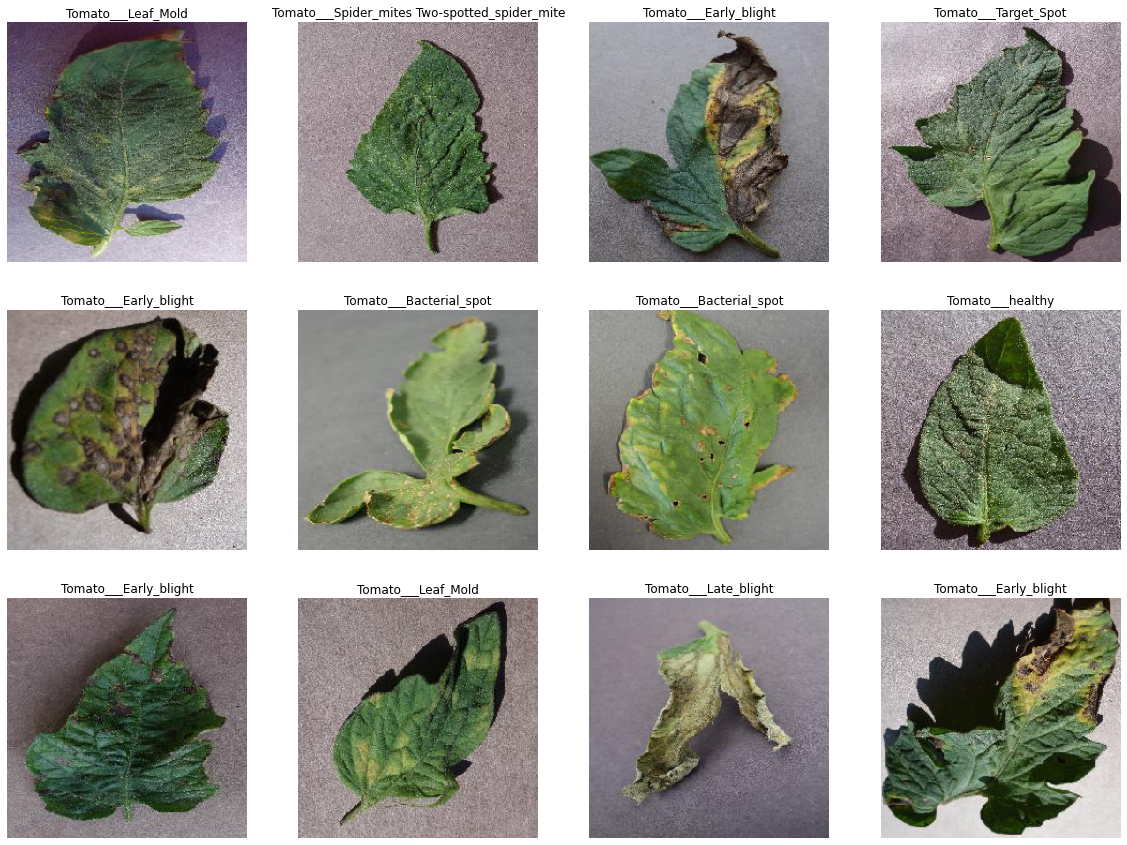

In [12]:
plot_images(ds_train, label_names)

In [13]:
def my_model():
  base_model=Xception(
      include_top=False,
      weights="imagenet",
      input_shape=(224, 224, 3)
  )
  base_model_output=base_model.output
  x = Flatten()(base_model_output)
  x = Dense(512, activation='relu')(x)
  x = Dense(len(label_names), activation='softmax')(x)
    
  model = Model(inputs=base_model.input, outputs=x)
  return model

In [14]:
model=my_model()

83683744/83683744 [==============================] - 5s 0us/step


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy']
              )

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [17]:
history = model.fit(ds_train,
                   validation_data=ds_val,
                   epochs=10,
                   steps_per_epoch=len(ds_train),
                   validation_steps=len(ds_val),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
125/125 [==============================] - 166s 1s/step - loss: 0.7462 - accuracy: 0.7515 - val_loss: 0.3929 - val_accuracy: 0.8725
Epoch 2/10
125/125 [==============================] - 140s 1s/step - loss: 0.1108 - accuracy: 0.9704 - val_loss: 0.3704 - val_accuracy: 0.8795
Epoch 3/10
125/125 [==============================] - 140s 1s/step - loss: 0.0298 - accuracy: 0.9961 - val_loss: 0.2089 - val_accuracy: 0.9325
Epoch 4/10
125/125 [==============================] - 141s 1s/step - loss: 0.0154 - accuracy: 0.9989 - val_loss: 0.1943 - val_accuracy: 0.9390
Epoch 5/10
125/125 [==============================] - 139s 1s/step - loss: 0.0095 - accuracy: 0.9996 - val_loss: 0.1928 - val_accuracy: 0.9410
Epoch 6/10
125/125 [==============================] - 139s 1s/step - loss: 0.0071 - accuracy: 0.9999 - val_loss: 0.1900 - val_accuracy: 0.9430
Epoch 7/10
125/125 [==============================] - 139s 1s/step - loss: 0.0048 - accuracy: 0.9999 - val_loss: 0.1897 - val_accuracy: 0.9440

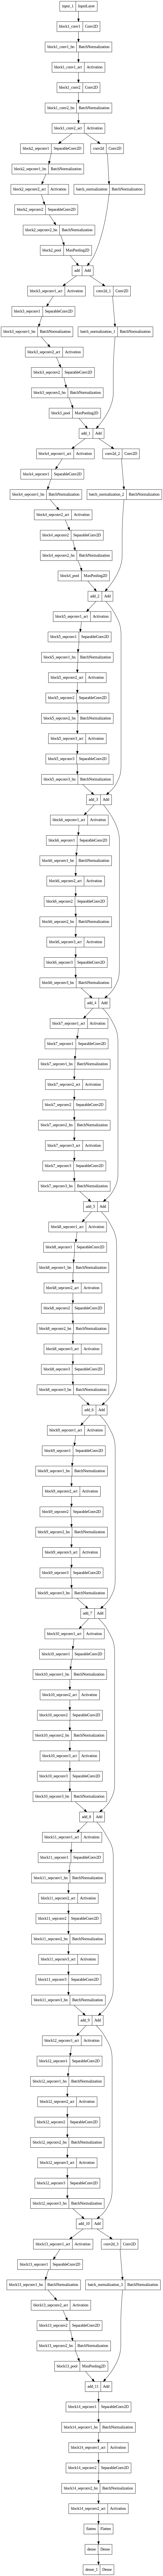

In [21]:
plot_model(model)

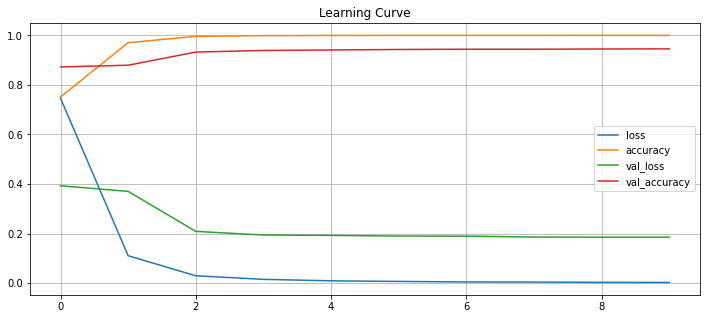

In [25]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(12, 5))
plt.title("Learning Curve")
plt.grid()

In [26]:
history.history

{'loss': [0.7462378740310669,
  0.11078237742185593,
  0.029791243374347687,
  0.01539896335452795,
  0.009473406709730625,
  0.007058774586766958,
  0.004828759469091892,
  0.004456725902855396,
  0.0033281687647104263,
  0.0029053869657218456],
 'accuracy': [0.7515000104904175,
  0.9703750014305115,
  0.9961249828338623,
  0.9988750219345093,
  0.999625027179718,
  0.999875009059906,
  0.999875009059906,
  0.999875009059906,
  1.0,
  1.0],
 'val_loss': [0.39291107654571533,
  0.3704330027103424,
  0.20894648134708405,
  0.19428901374340057,
  0.19276025891304016,
  0.1900150179862976,
  0.1896740049123764,
  0.18619365990161896,
  0.18566271662712097,
  0.1857038289308548],
 'val_accuracy': [0.8725000023841858,
  0.8794999718666077,
  0.9325000047683716,
  0.9390000104904175,
  0.9409999847412109,
  0.9430000185966492,
  0.9440000057220459,
  0.9440000057220459,
  0.9449999928474426,
  0.9455000162124634]}

In [28]:
history.on_predict_batch_end

<bound method Callback.on_predict_batch_end of <keras.callbacks.History object at 0x7fa4140d71c0>>

In [33]:
def predictImages(data, class_names, model):
    
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        
        
        i+=1
        if i > imgLen:
            break
            
    plt.show()

1/1 [==============================] - 0s 26ms/step


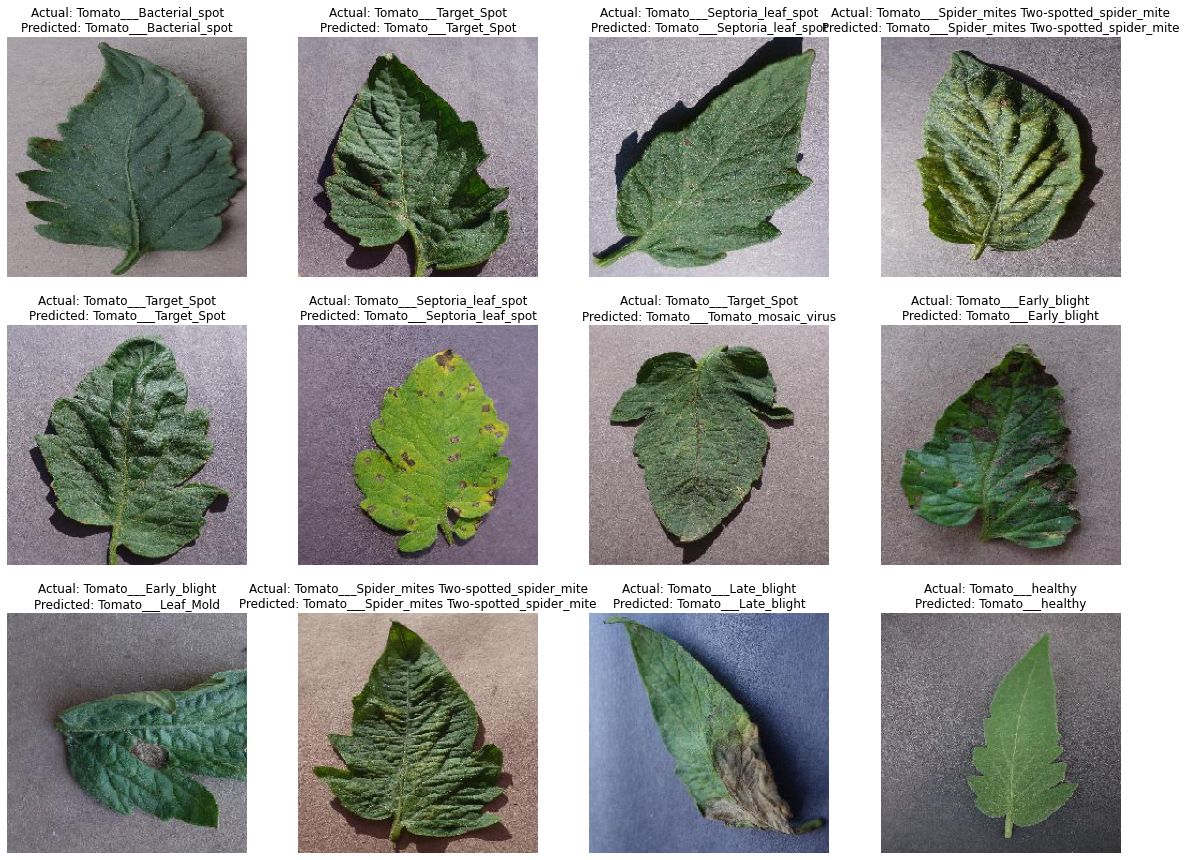

In [34]:
predictImages(ds_test, label_names, model)